# digit-recognizer

https://www.kaggle.com/competitions/digit-recognizer

## Setup

In [38]:
import os
from pathlib import Path
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable

import torchinfo

In [2]:
IS_KAGGLE = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
COMP_NAME = 'digit-recognizer'

if COMP_NAME is None:
    raise NameError('COMP_NAME has not been initialized')

RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

BATCH_SIZE = 100

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
print('kaggle:', 'Y' if IS_KAGGLE else 'N')
print('torch version:', torch.__version__)
print('device:', DEVICE)
print(torch.cuda.device_count(), 'GPU(s) available')

kaggle: N
torch version: 2.0.1
device: cuda:0
2 GPU(s) available


## Load Data

https://www.kaggle.com/competitions/digit-recognizer/data

In [4]:
if IS_KAGGLE: 
    path = Path('../input/' + COMP_NAME)
else:
    path = Path('./data')
    if not path.exists():
        import zipfile, kaggle
        kaggle.api.competition_download_cli(COMP_NAME)
        zipfile.ZipFile(f'{COMP_NAME}.zip').extractall(path)

In [5]:
train_data = pd.read_csv(path / 'train.csv')
test_data = pd.read_csv(path / 'test.csv')

print('train:', train_data.shape)
print('test: ', test_data.shape)

train: (42000, 785)
test:  (28000, 784)


In [6]:
X = train_data.iloc[:, :-1]
y = train_data.label.values

print('X:', X.shape, type(X))
print('y:', y.shape, type(y))

X: (42000, 784) <class 'pandas.core.frame.DataFrame'>
y: (42000,) <class 'numpy.ndarray'>


## Data Exploration

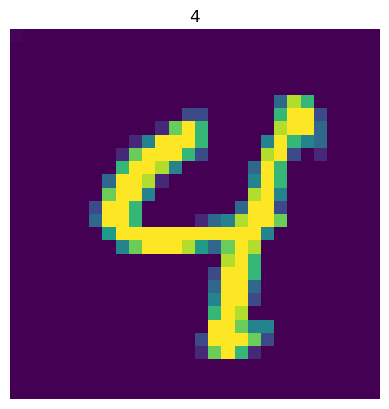

In [26]:
plt.imshow(X_train[3].reshape(28,28))
plt.axis('off')
plt.title(str(int(y[3])))
plt.show()

## Prepare Training/Validation Data

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

print('X_train:', X_train.shape, 'y_train:', y_train.shape)
print('X_valid:', X_valid.shape, 'y_valid:', y_valid.shape)

X_train: (33600, 784) y_train: (33600,)
X_valid: (8400, 784) y_valid: (8400,)


In [9]:
# normalize (0-255 -> 0-1)

X_train = X_train.values / 255
X_valid = X_valid.values / 255

In [10]:
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)

X_valid = torch.from_numpy(X_valid)
y_valid = torch.from_numpy(y_valid).type(torch.LongTensor)

print('X_train.dtype:', X_train.dtype)
print('y_train.dtype:', y_train.dtype)

X_train.dtype: torch.float64
y_train.dtype: torch.int64


In [11]:
train_ds = torch.utils.data.TensorDataset(X_train, y_train)
valid_ds = torch.utils.data.TensorDataset(X_valid, y_valid)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)

## Build Model

In [12]:
class DigitRecognizerModel(nn.Module):
    """
    Architecture summary:
      - Layer 1: Convolution 1 > Activation (ReLU) > Pooling 1 > Dropout 1
      - Layer 2: Convolution 2 > Activation (ReLU) > Pooling 2 > Dropout 2 > Flatten
      - Layer 3: Linear 1 > Activation (ReLU) > Dropout 3
      - Layer 4: Linear 2 > Activation (ReLU) > Dropout 4
      - Layer 5: Output > Activation (Softmax)
    """
    
    def __init__(self):
        super().__init__()

        # layer 1 
        # (black and white image, 1 color channel == 1 input channel)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=5, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.drop1 = nn.Dropout(p=0.3)

        # layer 2
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=224, kernel_size=5, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.drop2 = nn.Dropout(p=0.4)

        # layer 3
        self.linear1 = nn.Linear(in_features=224 * 4 * 4, out_features=64)
        self.drop3 = nn.Dropout(p=0.4)

        # layer 4
        self.linear2 = nn.Linear(in_features=64, out_features=32)
        self.drop4 = nn.Dropout(p=0.4)

        # layer 5
        self.linear3 = nn.Linear(in_features=32, out_features=10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.drop1(self.pool1(F.relu(self.conv1(x)))) # layer 1
        out = self.drop2(self.pool2(F.relu(self.conv2(out)))) # layer 2
        out = out.view(-1, 224 * 4 * 4) # flatten layer 2 outputs since layer 3 is linear
        
        out = self.drop3(F.relu(self.linear1(out))) # layer 3
        out = self.drop4(F.relu(self.linear2(out))) # layer 4
        out = self.softmax(self.linear3(out)) # layer 5
        return out

In [13]:
model = DigitRecognizerModel().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

DigitRecognizerModel(
  (conv1): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(128, 224, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.4, inplace=False)
  (linear1): Linear(in_features=3584, out_features=64, bias=True)
  (drop3): Dropout(p=0.4, inplace=False)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (drop4): Dropout(p=0.4, inplace=False)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [40]:
torchinfo.summary(model, (1, 28, 28), col_names=('input_size', 'output_size', 'num_params', 'kernel_size'), verbose=0)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
DigitRecognizerModel                     [1, 28, 28]               [1, 10]                   --                        --
├─Conv2d: 1-1                            [1, 28, 28]               [128, 24, 24]             3,328                     [5, 5]
├─MaxPool2d: 1-2                         [128, 24, 24]             [128, 12, 12]             --                        [2, 2]
├─Dropout: 1-3                           [128, 12, 12]             [128, 12, 12]             --                        --
├─Conv2d: 1-4                            [128, 12, 12]             [224, 8, 8]               717,024                   [5, 5]
├─MaxPool2d: 1-5                         [224, 8, 8]               [224, 4, 4]               --                        [2, 2]
├─Dropout: 1-6                           [224, 4, 4]               [224, 4, 4]               --                        -

## Train Model

In [14]:
epochs = 30
steps = 0
print_interval = 250

train_losses = []
valid_losses = []

for epoch in range(epochs):
    running_loss = 0
    
    for images, labels in train_loader:
        # forward pass
        steps += 1
        images = (images.view(-1, 1, 28, 28)).type(torch.DoubleTensor)
        optimizer.zero_grad()
        preds = model(images.type(torch.FloatTensor).to(DEVICE))
        labels = labels.to(DEVICE)
        loss = criterion(preds, labels)

        # back propagate
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # eval
        if steps % print_interval == 0:
            valid_loss = 0
            acc = 0
            with torch.no_grad():
                model.eval()
                for images, labels in valid_loader:
                    images = (images.view(-1, 1, 28, 28)).type(torch.DoubleTensor)
                    preds = model(images.type(torch.FloatTensor).to(DEVICE))
                    labels = labels.to(DEVICE)
                    valid_loss += criterion(preds, labels).item()
                    
                    ps = torch.exp(preds)
                    top_p, top_class = ps.topk(1, dim=1)
                    eq = top_class == labels.view(*top_class.shape)
                    acc += torch.mean(eq.type(torch.FloatTensor))

            # record/output performance
            train_losses.append(running_loss / len(train_loader))
            valid_losses.append(valid_loss / len(valid_loader))
            print(f'Epoch {epoch+1}/{epochs} - Accuracy: {acc / len(valid_loader)}')

            # re-enable training
            model.train()
                    

Epoch 1/30 - Accuracy: 0.9434522986412048
Epoch 2/30 - Accuracy: 0.959047794342041
Epoch 3/30 - Accuracy: 0.9653573036193848
Epoch 3/30 - Accuracy: 0.9665476679801941
Epoch 4/30 - Accuracy: 0.970000147819519
Epoch 5/30 - Accuracy: 0.9705954194068909
Epoch 6/30 - Accuracy: 0.9755952954292297
Epoch 6/30 - Accuracy: 0.9783337712287903
Epoch 7/30 - Accuracy: 0.9792858958244324
Epoch 8/30 - Accuracy: 0.9797620177268982
Epoch 9/30 - Accuracy: 0.9819048643112183
Epoch 9/30 - Accuracy: 0.9784528017044067
Epoch 10/30 - Accuracy: 0.9820238947868347
Epoch 11/30 - Accuracy: 0.9819051623344421
Epoch 12/30 - Accuracy: 0.9816668629646301
Epoch 12/30 - Accuracy: 0.9825002551078796
Epoch 13/30 - Accuracy: 0.9804766774177551
Epoch 14/30 - Accuracy: 0.982381284236908
Epoch 15/30 - Accuracy: 0.9824999570846558
Epoch 15/30 - Accuracy: 0.9840480089187622
Epoch 16/30 - Accuracy: 0.983571469783783
Epoch 17/30 - Accuracy: 0.9802382588386536
Epoch 18/30 - Accuracy: 0.9841669201850891
Epoch 18/30 - Accuracy: 0.9

## Evaluate Model

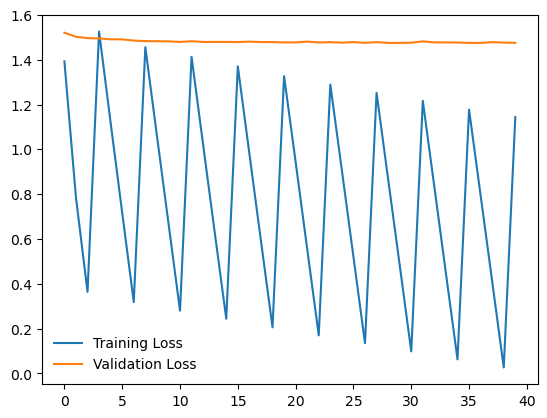

In [15]:
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend(frameon=False)

## Submission

In [16]:
X_test = test_data.values
X_test = torch.from_numpy(X_test / 255)

y_test = np.zeros(X_test.shape)
y_test = torch.from_numpy(y_test)

test_ds = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
submission_rows = [['ImageId', 'Label']]

with torch.no_grad():
    model.eval()
    image_id = 1
    for images, _ in test_loader:
        images = (images.view(-1, 1, 28, 28)).type(torch.DoubleTensor)
        preds = model(images.type(torch.FloatTensor).to(DEVICE))
        ps = torch.exp(preds)
        top_p, top_class = ps.topk(1, dim=1)

        for pred in top_class:
            submission_rows.append([image_id, pred.item()])
            image_id += 1

submission = pd.DataFrame(submission_rows)
submission.columns = submission.iloc[0]
submission = submission.drop(0, axis=0)

submission.to_csv('submission.csv', index=False)